<a href="https://colab.research.google.com/github/Salilg3/RAG_CRM/blob/main/CRM_SmartAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install -q langchain-google-genai chromadb pandas matplotlib langchain_community seaborn google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.5 MB/s eta 0:00:0

In [87]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving realestate_crm_bi.sql to realestate_crm_bi (1).sql


In [94]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai
from datetime import datetime
import os
import re
from langchain_google_genai import ChatGoogleGenerativeAI

plt.style.use('default')
sns.set_palette("husl")

class SQL_Manange:
  def __init__(self,db_path="crm_bi.db"):
      self.db_path= db_path
      self.context_cache ={}

  def setup_database(self, sql_file_path="realestate_crm_bi.sql"):
        try:
            if not os.path.exists(sql_file_path):
                raise FileNotFoundError(f"SQL file '{sql_file_path}' not found. Please upload it first.")

            with open(sql_file_path, 'r', encoding='utf-8') as file:
                sql_content = file.read()

            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()
            cursor.execute("PRAGMA foreign_keys = ON;")
            cursor.executescript(sql_content)
            conn.commit()
            conn.close()

            self._verify_setup()
            self._build_initial_query()
            print("Database ready to use as context.")
            return True

        except Exception as e:
          print(f"Database setup failed with a specific error: {e}")
          return False

  def _verify_setup(self):
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()
        tables = ['agents', 'customers', 'properties', 'transactions']
        print("\nDatabase Contents:")
        for table in tables:
            cursor.execute(f"SELECT COUNT(*) FROM {table}")
            count = cursor.fetchone()[0]
            print(f"  {table.capitalize()}: {count} records")
        conn.close()

  def _build_initial_query(self):
        conn = sqlite3.connect(self.db_path)
        try:
            regions_query = """
            SELECT a.region, COUNT(DISTINCT a.agent_id) as agent_count, COUNT(DISTINCT c.customer_id) as customer_count,
                   COUNT(DISTINCT p.property_id) as property_count, COUNT(DISTINCT t.transaction_id) as transaction_count,
                   ROUND(AVG(p.price), 2) as avg_property_price, SUM(t.amount) as total_revenue
            FROM agents a
            LEFT JOIN customers c ON a.region = c.region
            LEFT JOIN properties p ON a.region = p.region
            LEFT JOIN transactions t ON a.agent_id = t.agent_id
            WHERE t.status = 'Completed'
            GROUP BY a.region ORDER BY total_revenue DESC
            """
            self.context_cache['regional_insights'] = pd.read_sql_query(regions_query, conn)

            top_agents_query = "SELECT name, region, specialization, total_sales, commission_rate FROM agents ORDER BY total_sales DESC LIMIT 10"
            self.context_cache['top_agents'] = pd.read_sql_query(top_agents_query, conn)

            monthly_trends_query = """
            SELECT strftime('%Y-%m', transaction_date) as month, COUNT(*) as transaction_count,
                   SUM(amount) as total_amount, AVG(amount) as avg_amount
            FROM transactions WHERE status = 'Completed'
            GROUP BY month ORDER BY month
            """
            self.context_cache['market_trends'] = pd.read_sql_query(monthly_trends_query, conn)

            property_insights_query = """
            SELECT property_type, COUNT(*) as count, AVG(price) as avg_price,
                   MIN(price) as min_price, MAX(price) as max_price
            FROM properties GROUP BY property_type ORDER BY avg_price DESC
            """
            self.context_cache['property_insights'] = pd.read_sql_query(property_insights_query, conn)

            customer_segments_query = """
            SELECT customer_type, budget_range, COUNT(*) as count, region
            FROM customers GROUP BY customer_type, budget_range, region
            ORDER BY count DESC
            """
            self.context_cache['customer_segments'] = pd.read_sql_query(customer_segments_query, conn)

        except Exception as e:
            print(f"Context building warning: {e}")

        finally:
            conn.close()
  def execute_query(self, sql):
        try:
            conn = sqlite3.connect(self.db_path)
            df = pd.read_sql_query(sql, conn)
            conn.close()
            return df
        except Exception as e:
            return f"SQL Error: {e}"




class LLM_Handling:
    def __init__(self,api_key):
        self.llm = None
        try:
            self.llm = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash",
            temperature=0.2,
        )
        except Exception as e:
            print(f"Gemini setup failed: {e}")

    def generate_sql_with_rag(self, user_query, relevant_context):
        schema_context = """
        You are a SQL expert for a Real Estate CRM system with RAG enhancement.
        Provide a detailed, data-driven answer. If the question involves numbers or comparisons, be specific with figures and round them off to the nearest hundred if more than 5 digits in the figure.
        Database schema:
        TABLES:
        1. agents (agent_id, name, email, phone, region, specialization, hire_date, commission_rate, total_sales, status)
        2. customers (customer_id, name, email, phone, region, customer_type, budget_range, registration_date, last_activity_date, status)
        3. properties (property_id, address, region, property_type, bedrooms, price, square_feet, listing_date, status, agent_id)
        4. transactions (transaction_id, customer_id, property_id, agent_id, transaction_date, transaction_type, amount, commission, status)
        RULES:
        1. Generate ONLY valid SQLite queries.
        2. If user wants charts, return "CHART:" + SQL query.
        3. For scatter plots, ensure query returns 2 numeric columns.
        4. For funnel charts, order data in descending stages.
        5. Use the contextual insights provided to generate more accurate queries.
        6. Return only SQL, no explanations.
        7. CRITICAL: The query MUST begin with 'SELECT' or 'WITH'. Do not add any other text before the SQL query specially ite.
        """
        rag_prompt = f"""
        {schema_context}
        RETRIEVED CONTEXTUAL DATA (Use this to inform your SQL generation):
        {relevant_context}
        User Query: {user_query}
        Based on the above context and user query, generate the most appropriate SQL query:
        """
        try:
            response = self.llm.invoke(rag_prompt)
            return response.content.strip()
        except Exception as e:
            return f"AI Error: {e}"

    def generate_rag_insights(self, query_result, user_query,relevant_context):
        if isinstance(query_result, str) or query_result.empty:
            return "No insights available."

        insights_prompt = f"""
        Based on the following query results and contextual data, provide key business insights:
        USER QUERY: {user_query}
        QUERY RESULTS:
        {query_result.to_string(index=False)}
        BUSINESS CONTEXT:
        {relevant_context}
        Provide 3-4 key insights in numbered point that would be valuable for real estate business decision making and make the data analysis short and concise for the user:
        """
        try:
            response = self.llm.invoke(insights_prompt)
            return response.content.strip()
        except Exception as e:
            return f"Insights generation error: {e}"

class Main_Execution:
    def __init__(self,api_key):
        self.db_manager = SQL_Manange()
        self.llm_client = LLM_Handling(api_key)
        self.chart_generator = Chart_Generator()

    def setup(self, sql_file = "realestate_crm_bi.sql"):
      return self.db_manager.setup_database(sql_file)

    def enhanced_query_context(self, user_query):
        relevant_context = []
        query_lower = user_query.lower()

        if any(word in query_lower for word in ['region', 'mumbai', 'bangalore', 'pune', 'delhi', 'chennai']):
            regional_data = self.db_manager.context_cache.get('regional_insights')
            if regional_data is not None and not regional_data.empty:
                relevant_context.append("REGIONAL INSIGHTS:")
                relevant_context.append(regional_data.head().to_string(index=False))
                relevant_context.append("")

        if any(word in query_lower for word in ['agent', 'performance', 'sales', 'top', 'best']):
            agent_data = self.db_manager.context_cache.get('top_agents')
            if agent_data is not None and not agent_data.empty:
                relevant_context.append("TOP AGENT PERFORMANCE:")
                relevant_context.append(agent_data.head().to_string(index=False))
                relevant_context.append("")

        if any(word in query_lower for word in ['trend', 'monthly', 'time', 'period', 'growth']):
            trend_data = self.db_manager.context_cache.get('market_trends')
            if trend_data is not None and not trend_data.empty:
                relevant_context.append("MARKET TRENDS:")
                relevant_context.append(trend_data.tail().to_string(index=False))
                relevant_context.append("")

        if any(word in query_lower for word in ['property', 'price', 'apartment', 'villa', 'office']):
            property_data = self.db_manager.context_cache.get('property_insights')
            if property_data is not None and not property_data.empty:
                relevant_context.append("PROPERTY MARKET INSIGHTS:")
                relevant_context.append(property_data.to_string(index=False))
                relevant_context.append("")

        if any(word in query_lower for word in ['customer', 'client', 'buyer', 'budget']):
            customer_data = self.db_manager.context_cache.get('customer_segments')
            if customer_data is not None and not customer_data.empty:
                relevant_context.append("CUSTOMER SEGMENTS:")
                relevant_context.append(customer_data.head(10).to_string(index=False))
                relevant_context.append("")

        return "\n".join(relevant_context)

    def process_output(self, user_query):
        print("\n" + "="*100)
        print(f"Processing Query: {user_query}")
        print("="*100)
        context = self.enhanced_query_context(user_query)
        ai_response = self.llm_client.generate_sql_with_rag(user_query,context)

        is_chart = ai_response.startswith("CHART:")
        if is_chart:
            ai_response = ai_response.replace("CHART:", "", 1).strip()
        sql_query = ""
        match = re.search(r"```sql(.*?)```", ai_response, re.DOTALL)

        if match:
            sql_query = match.group(1).strip()
        else:
            sql_query = ai_response.strip()

        if not sql_query:
            print("AI did not return a valid SQL query.")
            return
        print(f"\nGenerated SQL Query:")
        print("-" * 50)
        print(sql_query)
        print("-" * 50)

        result = self.db_manager.execute_query(sql_query)

        if isinstance(result, str):
            print(result)
            return

        if result.empty:
            print("No results found")
            return

        print(f"\nQuery Results ({len(result)} records):")
        print("=" * 100)
        print(result.to_string(index=False))

        print("\nInsights Based on the data feeded and query:")
        print("=" * 100)
        insights = self.llm_client.generate_rag_insights(result, user_query, context)
        print(insights)

        if is_chart or any(word in user_query.lower() for word in ['chart', 'graph', 'plot', 'bar', 'pie', 'line', 'scatter', 'funnel']):
            chart_type = self.chart_generator.select_chart(user_query)
            print(f"\nCreating {chart_type.upper()} chart...")
            self.chart_generator.create_graph(result, chart_type,f"Your Desired Graph/Chart")
        print("\n" + "="*100)

class Chart_Generator:
  def select_chart(self, user_query):

        query_lower = user_query.lower()
        if 'line chart' in query_lower or 'line graph' in query_lower or 'trend' in query_lower:
            return 'line'
        elif 'scatter plot' in query_lower or 'scatter chart' in query_lower or 'correlation' in query_lower:
            return 'scatter'
        elif 'pie chart' in query_lower or 'pie graph' in query_lower:
            return 'pie'
        elif 'funnel chart' in query_lower or 'funnel graph' in query_lower or 'conversion' in query_lower:
            return 'funnel'
        elif 'bar chart' in query_lower or 'bar graph' in query_lower or 'comparison' in query_lower:
            return 'bar'
        else:
            return 'bar'
  def create_graph(self, df, chart_type, title):
        if df.empty:
            print("No data to visualize")
            return
        plt.figure(figsize=(14, 8))
        x_col, y_col = None, None
        for col in df.columns:
          if x_col is None and pd.api.types.is_string_dtype(df[col]):
              x_col = col
          if y_col is None and pd.api.types.is_numeric_dtype(df[col]):
              y_col = col

        if x_col is None: ## For scatter plot since both are numbers in this case.
          x_col = df.columns[0]
        if y_col is None:
          y_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

        if chart_type == 'bar':
            bars = plt.bar(df[x_col], df[y_col], color='steelblue', alpha=0.8, edgecolor='navy')
            plt.xticks(rotation=45, ha='right')
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)
            plt.ylabel(y_col.replace('_', ' ').title())
            plt.xlabel(x_col.replace('_', ' ').title())

        elif chart_type == 'line':
            plt.plot(df[x_col], df[y_col], marker='o', linewidth=3, markersize=8, color='steelblue')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
            plt.ylabel(y_col.replace('_', ' ').title())
            plt.xlabel(x_col.replace('_', ' ').title())

        elif chart_type == 'scatter':
            if len(df.columns) >= 2:
                plt.scatter(df[x_col], df[y_col], alpha=0.7, s=100, color='steelblue', edgecolor='navy')
                plt.xlabel(x_col.replace('_', ' ').title())
                plt.ylabel(y_col.replace('_', ' ').title())
                plt.grid(True, alpha=0.3)
                try:
                    correlation = df[x_col].corr(df[y_col])
                    plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12,
                             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
                except:
                    pass
            else:
                print("Scatter plot requires 2 numeric columns")
                return

        elif chart_type == 'pie':
            colors = plt.cm.Set3(np.linspace(0, 1, len(df)))
            wedges, texts, autotexts = plt.pie(df[y_col], labels=df[x_col], autopct='%1.1f%%', startangle=90, colors=colors)
            plt.axis('equal')
            for text in texts:
                text.set_fontsize(10)
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')

        elif chart_type == 'funnel':
            if len(df.columns) >= 2:
                df['label'] = df.iloc[:, 0].astype(str) + ' - ' + df.iloc[:, 1].astype(str)
                value_col = df.columns[-2]
                labels = df['label']
                values = df[value_col]
                sort_indices = values.argsort()[::-1]
                labels = labels[sort_indices]
                values = values[sort_indices]
                y_pos = np.arange(len(labels))
                bars = plt.barh(y_pos, values, color='steelblue', alpha=0.8)
                plt.yticks(y_pos, labels)
                plt.xlabel(value_col.replace('_', ' ').title())

                for i, bar in enumerate(bars):
                    width = bar.get_width()
                    plt.text(width + values.max() * 0.01, bar.get_y() + bar.get_height()/2,
                             f'{width:,.0f}', ha='left', va='center', fontsize=10, fontweight='bold')

                plt.gca().invert_yaxis()
            else:
                print("Funnel chart requires at least two columns (category and value).")
                return

        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()



def input_user_query():
    print("=" * 100)
    print("AI Agent for CRM Data")
    print("=" * 100)
    alpha = Main_Execution(api_key=API_KEY)

    if not alpha.setup():
        print("Failed to setup database. Make sure the SQL file is uploaded.")
        return

    print("\nEnter your query and specify what type of graph/chart if needed:")
    user_query = input("Your Query: ").strip()
    if not user_query:
        print("Query required")
        return

    alpha.process_output(user_query)
    print("\nQuery completed!\nTo run another query, execute the cell again or call input_user_query()")

AI Agent for CRM Data

Database Contents:
  Agents: 15 records
  Customers: 40 records
  Properties: 60 records
  Transactions: 80 records
Database ready to use as context.

Enter your query and specify what type of graph/chart if needed:
Your Query: Show me the top 3 agents in Mumbai region who closed deals above 5 million in the last 6 months with their customer satisfaction metrics as a bar chart with market insights

Processing Query: Show me the top 3 agents in Mumbai region who closed deals above 5 million in the last 6 months with their customer satisfaction metrics as a bar chart with market insights

Generated SQL Query:
--------------------------------------------------
SELECT
  A.name AS agent_name,
  ROUND(SUM(T.amount), -2) AS total_deal_value
FROM agents AS A
JOIN transactions AS T
  ON A.agent_id = T.agent_id
WHERE
  A.region IN ('Central Mumbai', 'North Mumbai') AND T.amount > 5000000 AND T.transaction_date >= date('now', '-6 months')
GROUP BY
  A.agent_id,
  A.name
ORD

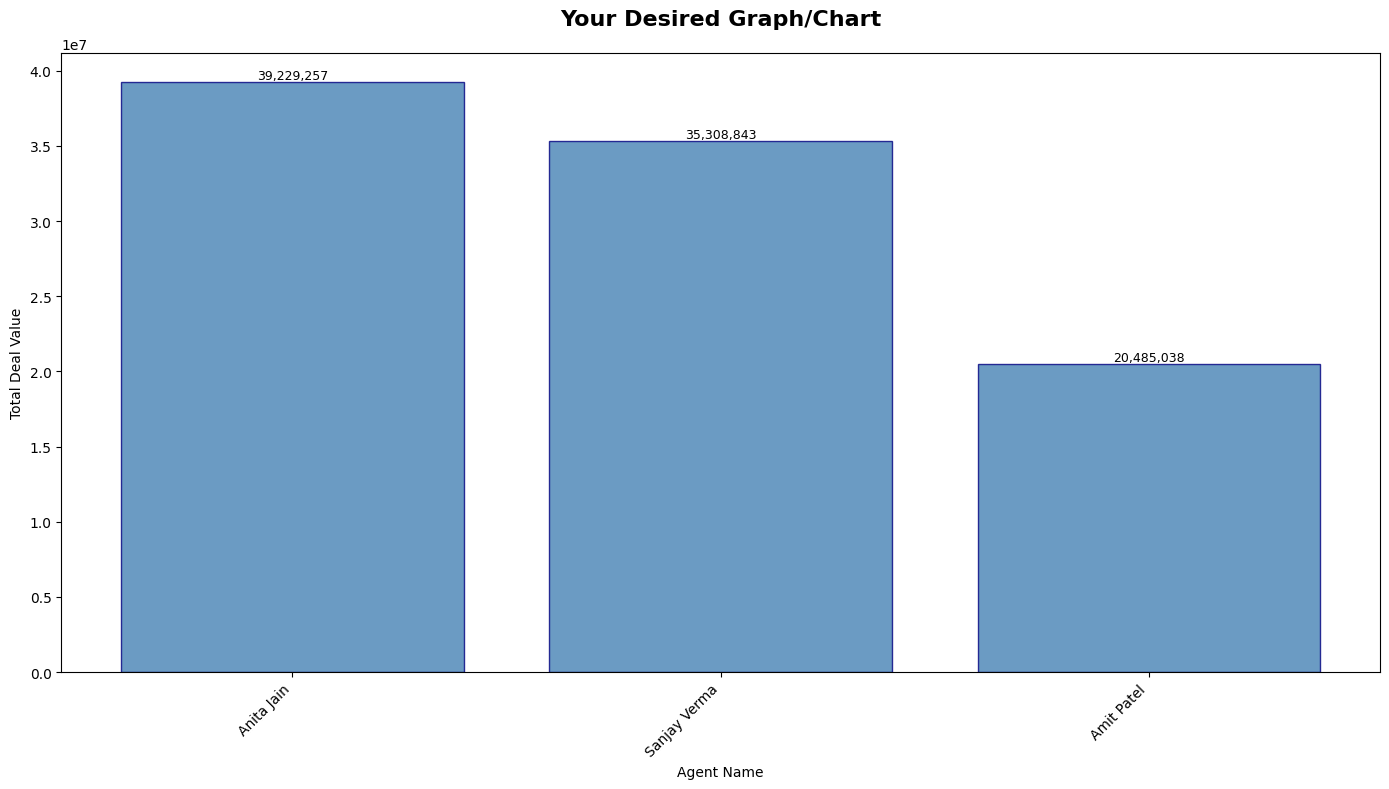



Query completed!
To run another query, execute the cell again or call input_user_query()


In [95]:
input_user_query()